In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

Text(0, 0.5, 'returns')

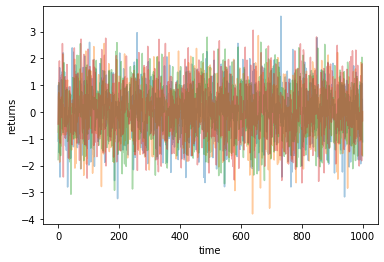

In [3]:
np.random.seed(123)
n_assets = 4 #num of assets
n_obs = 1000 #num of observations
return_vec = np.random.randn(n_assets, n_obs)

plt.plot(return_vec.T, alpha=.4)
plt.xlabel('time')
plt.ylabel('returns')


In [4]:
def rand_weights(n):
    '''produce n random weights that sum to 1'''
    k = np.random.rand(n)
    return k/sum(k)
print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [5]:
def random_portfolio(returns):
    '''returns the mean and standard deviation of returns for a random portfolio'''
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    c = np.asmatrix(np.cov(returns))
    mu = w * p.T
    sigma = np.sqrt(w * c * w.T)
    #this recursion reduce outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma


Text(0.5, 1.0, 'mean and std of returns of randomly generated portfolios')

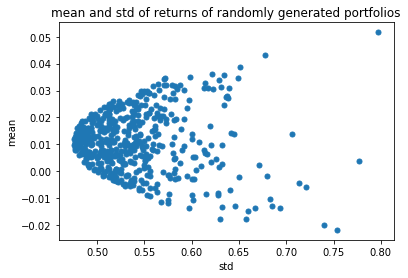

In [6]:
n_portfolios = 500
means, stds = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('mean and std of returns of randomly generated portfolios')

     pcost       dcost       gap    pres   dres
 0: -5.0267e-03 -1.0500e+00  1e+00  2e-16  3e+00
 1: -7.0118e-03 -5.7796e-02  5e-02  1e-16  1e-01
 2: -2.1272e-02 -3.2067e-02  1e-02  1e-16  4e-17
 3: -2.3343e-02 -2.3817e-02  5e-04  3e-17  2e-17
 4: -2.3609e-02 -2.3614e-02  6e-06  2e-16  2e-17
 5: -2.3612e-02 -2.3612e-02  6e-08  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5722e-03 -1.0480e+00  1e+00  6e-17  3e+00
 1: -5.5000e-03 -5.5617e-02  5e-02  7e-17  1e-01
 2: -1.8307e-02 -2.8145e-02  1e-02  1e-16  3e-17
 3: -2.0236e-02 -2.0675e-02  4e-04  1e-16  3e-18
 4: -2.0527e-02 -2.0533e-02  6e-06  2e-16  5e-18
 5: -2.0532e-02 -2.0532e-02  6e-08  1e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9432e-03 -1.0458e+00  1e+00  6e-17  3e+00
 1: -3.8092e-03 -5.3194e-02  5e-02  2e-16  1e-01
 2: -1.5246e-02 -2.4104e-02  9e-03  1e-16  4e-17
 3: -1.7023e-02 -1.7502e-02  5e-04  2e-16  1e-17
 4: -1.7346e-02 -1.7354e

 1:  1.1230e+02  1.1229e+02  1e-02  7e-17  3e-02
 2:  1.1230e+02  1.1230e+02  1e-04  6e-17  3e-04
 3:  1.1230e+02  1.1230e+02  1e-06  8e-17  3e-06
 4:  1.1230e+02  1.1230e+02  1e-08  1e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2601e+02  1.2499e+02  1e+00  3e-17  3e+00
 1:  1.2601e+02  1.2600e+02  1e-02  8e-17  3e-02
 2:  1.2601e+02  1.2601e+02  1e-04  6e-17  3e-04
 3:  1.2601e+02  1.2601e+02  1e-06  6e-17  3e-06
 4:  1.2601e+02  1.2601e+02  1e-08  1e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4138e+02  1.4037e+02  1e+00  6e-17  3e+00
 1:  1.4138e+02  1.4137e+02  1e-02  9e-17  3e-02
 2:  1.4138e+02  1.4138e+02  1e-04  6e-17  3e-04
 3:  1.4138e+02  1.4138e+02  1e-06  8e-17  3e-06
 4:  1.4138e+02  1.4138e+02  1e-08  8e-17  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5864e+02  1.5762e+02  1e+00  6e-17  3e+00
 1:  1.5864e+02  1.5863e+02  1e-02  9e-17  3e-02


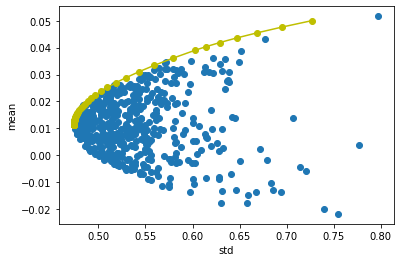

In [7]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    N = 100
    mus = [10**(5.0 * t/N -1.0) for t in range(N)]
    #convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    #constraint matrices
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    #efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    #risks and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    #calculate the 2nd degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    #calculate optimal portfolio
    wt = solvers.qp(opt.matrix(x1*S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [8]:
print(weights)

[[2.77880107e-09]
 [3.20322848e-06]
 [1.54301198e-06]
 [9.99995251e-01]]


In [9]:
'''
min 0.5 x^t P x + q x
subject to
G x <= h
A x = b

all numbers should be doubles, not intergers
column-wise, not row-wise like np
'''

'''
min 0.5x^2 +3x+4y
subject to
x, y ≥ 0
x + 3y ≥ 15 
2x + 5y ≤ 100 
3x + 4y ≤ 80
'''

P = opt.matrix([[1.0,0.0],[0.0,0.0]])
q = opt.matrix([3.0,4.0])
G = opt.matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = opt.matrix([0.0,0.0,-15.0,100.0,80.0])

sol = opt.solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.


In [10]:
print(type(sol))
print(sol.keys())
print('solution is {}'.format(sol['x']))
print('optimal value is {}'.format(sol['primal objective']))

<class 'dict'>
dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])
solution is [ 7.13e-07]
[ 5.00e+00]

optimal value is 20.00000617311241


In [1]:
import matplotlib.pyplot as plt
import numpy as np

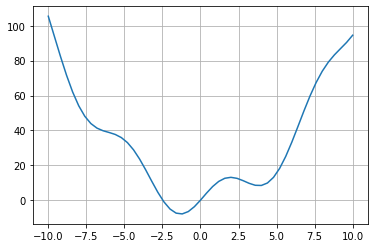

In [4]:
def f(x):
    return x**2+10*np.sin(x)

x=np.linspace(-10,10,51)
y=f(x)

#fig=plt.figure(figsize=(5,4), dpi=80)
plt.plot(x,y)
plt.grid('on')
plt.show()

In [5]:
import scipy.optimize as opt

In [6]:
[xopt,fopt,gopt,bopt,func_calls,grad_calls,warnflg]= \
opt.fmin_bfgs(f,x0=6,maxiter=2000,full_output=True)

Optimization terminated successfully.
         Current function value: 8.315586
         Iterations: 7
         Function evaluations: 24
         Gradient evaluations: 8


In [7]:
print(xopt,fopt)

[3.83746709] 8.315585579477458


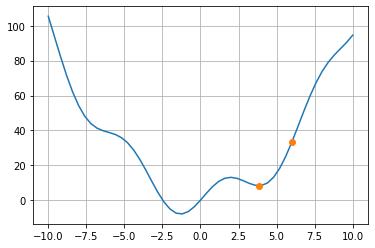

In [10]:
x0=6
plt.plot(x,y)
plt.plot([x0,xopt],[f(x0),fopt],'o')
plt.grid('on')
plt.show()

In [12]:
res=opt.basinhopping(f,x0=6,T=1,stepsize=2)
res

                        fun: -7.9458233756152845
 lowest_optimization_result:       fun: -7.9458233756152845
 hess_inv: array([[0.08577579]])
      jac: array([1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 3
     njev: 8
   status: 0
  success: True
        x: array([-1.30644001])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1821
                        nit: 100
                       njev: 607
                          x: array([-1.30644001])

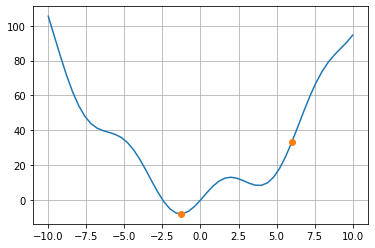

In [14]:
x0=6
plt.plot(x,y)
plt.plot([x0,res.x],[f(x0),res.fun],'o')
plt.grid('on')
plt.show()

In [16]:
#linear programming using pulp
#max z=20x1 + 30x2
#s.t x1+2x2 <=100
#2x1+x2<=100
#x1>=0
#x2>=0

#from pulp import *
#prob = LpProblem('Giapetto',LpMaximize)
#x1 = LpVariable('x1', lowbound=0, cat='Integer')
#x2 = LpVariable('x2', lowbound=0, cat='Integer')
#prob += 20*x1 + 30*x2
#prob += x1 + 2*x2 <= 200
#prob += 2*x1 + x2 <= 100
#prob
#status = prob.solve()
#LpStatus[status]
#value(x1), value(x2), value(prob.objective)